In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix, classification_report

# Load the dataset
df= pd.read_csv('/content/Base.csv')



In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324383 entries, 0 to 324382
Data columns (total 32 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   fraud_bool                        324383 non-null  int64  
 1   income                            324383 non-null  float64
 2   name_email_similarity             324383 non-null  float64
 3   prev_address_months_count         324383 non-null  int64  
 4   current_address_months_count      324383 non-null  int64  
 5   customer_age                      324383 non-null  int64  
 6   days_since_request                324383 non-null  float64
 7   intended_balcon_amount            324382 non-null  float64
 8   payment_type                      324382 non-null  object 
 9   zip_count_4w                      324382 non-null  float64
 10  velocity_6h                       324382 non-null  float64
 11  velocity_24h                      324382 non-null  f

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams

In [4]:
# Set the figure size for plots
rcParams['figure.figsize'] = 14, 8


In [5]:
# Set random seed
RANDOM_SEED = 42

# Labels for plot
LABELS = ["Normal", "Fraud"]


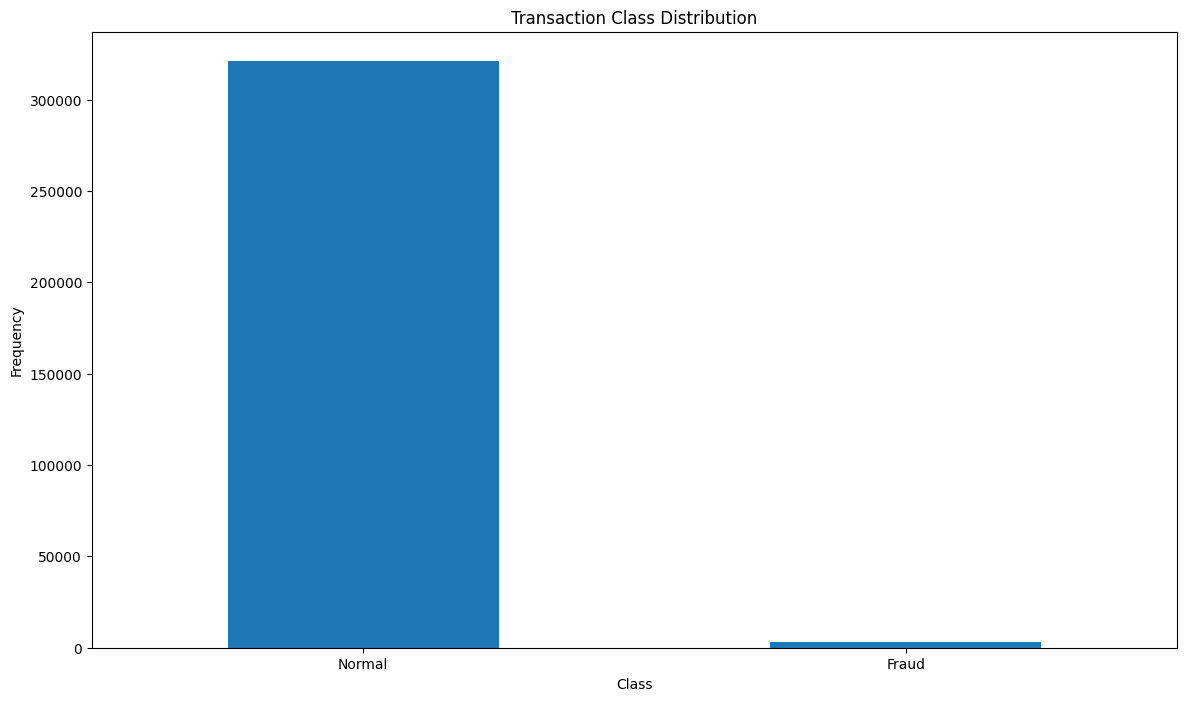

In [6]:
# Determine the number of fraud and valid transactions in the entire dataset
count_classes = pd.value_counts(df['fraud_bool'], sort=True)
count_classes.plot(kind='bar', rot=0)
plt.title("Transaction Class Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

In [7]:
# Assigning the transaction class "0 = NORMAL  & 1 = FRAUD"
Normal = df[df['fraud_bool'] == 0]
Fraud = df[df['fraud_bool'] == 1]

In [8]:
# Print outlier fraction
outlier_fraction = len(Fraud) / float(len(Normal))
print(outlier_fraction)
print("Fraud Cases : {}".format(len(Fraud)))
print("Normal Cases : {}".format(len(Normal)))

0.010038641296055847
Fraud Cases : 3224
Normal Cases : 321159


In [9]:
# Sample a fraction of the dataset
df1 = df.sample(frac=0.1, random_state=1)
Normal1 = df1[df1['fraud_bool'] == 0]
Fraud1 = df1[df1['fraud_bool'] == 1]
outlier_fraction1 = len(Fraud1) / float(len(Normal1))
print(outlier_fraction1)
print("Fraud Cases : {}".format(len(Fraud1)))
print("Normal Cases : {}".format(len(Normal1)))

0.009774623334578509
Fraud Cases : 314
Normal Cases : 32124


In [10]:
print(df1.columns.tolist())


['fraud_bool', 'income', 'name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'customer_age', 'days_since_request', 'intended_balcon_amount', 'payment_type', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'employment_status', 'credit_risk_score', 'email_is_free', 'housing_status', 'phone_home_valid', 'phone_mobile_valid', 'bank_months_count', 'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source', 'session_length_in_minutes', 'device_os', 'keep_alive_session', 'device_distinct_emails_8w', 'device_fraud_count', 'month']


In [11]:
# Print column names in df1
print(df1.columns)


Index(['fraud_bool', 'income', 'name_email_similarity',
       'prev_address_months_count', 'current_address_months_count',
       'customer_age', 'days_since_request', 'intended_balcon_amount',
       'payment_type', 'zip_count_4w', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'employment_status',
       'credit_risk_score', 'email_is_free', 'housing_status',
       'phone_home_valid', 'phone_mobile_valid', 'bank_months_count',
       'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source',
       'session_length_in_minutes', 'device_os', 'keep_alive_session',
       'device_distinct_emails_8w', 'device_fraud_count', 'month'],
      dtype='object')


In [15]:
print(df1.columns)

Index(['fraud_bool', 'income', 'name_email_similarity',
       'prev_address_months_count', 'current_address_months_count',
       'customer_age', 'days_since_request', 'intended_balcon_amount',
       'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w',
       'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w',
       'credit_risk_score', 'email_is_free', 'phone_home_valid',
       'phone_mobile_valid', 'bank_months_count', 'has_other_cards',
       'proposed_credit_limit', 'foreign_request', 'session_length_in_minutes',
       'keep_alive_session', 'device_distinct_emails_8w', 'device_fraud_count',
       'month', 'housing_status_BA', 'housing_status_BB', 'housing_status_BC',
       'housing_status_BD', 'housing_status_BE', 'housing_status_BF',
       'housing_status_BG', 'payment_type_AA', 'payment_type_AB',
       'payment_type_AC', 'payment_type_AD', 'payment_type_AE',
       'employment_status_CA', 'employment_status_CB', 'employment_status_CC',
       'employmen

In [16]:


# Get all the columns from the dataframe after one-hot encoding
columns = df1.columns.tolist()

# Filter the columns to remove data we do not want
columns = [c for c in columns if c not in ["fraud_bool"]]

# Store the variable we are predicting
target = "fraud_bool"

# Define X and Y
X = df1[columns]
Y = df1[target]

# Define the outlier detection methods
outlier_fraction = 0.1
state = 0
classifiers = {
    "Isolation Forest": IsolationForest(n_estimators=100, max_samples=len(X),
                                        contamination=outlier_fraction, random_state=state, verbose=0),
    "Local Outlier Factor": LocalOutlierFactor(n_neighbors=20, algorithm='auto',
                                               leaf_size=30, metric='minkowski', p=2, metric_params=None,
                                               contamination=outlier_fraction),
    "Support Vector Machine": OneClassSVM(kernel='rbf', degree=3, gamma=0.1, nu=0.05, max_iter=-1)
}

In [22]:
# Fit the model
n_outliers = len(Fraud)
for clf_name, clf in classifiers.items():
    # Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X)
        y_pred = clf.predict(X)
    else:
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)

    # Reshape the prediction values to 0 for Normal transactions and 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1

    # Count errors
    n_errors = (y_pred != Y).sum()

    # Print Classification Metrics
    print("{}: {}".format(clf_name, n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y, y_pred))
    print("Classification Report :")
    print(classification_report(Y, y_pred))


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Isolation Forest: 3452
Accuracy Score :
0.89358160182502
Classification Report :
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     32124
           1       0.02      0.17      0.03       314

    accuracy                           0.89     32438
   macro avg       0.50      0.53      0.49     32438
weighted avg       0.98      0.89      0.93     32438

Local Outlier Factor: 3468
Accuracy Score :
0.8930883531660398
Classification Report :
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     32124
           1       0.01      0.14      0.03       314

    accuracy                           0.89     32438
   macro avg       0.50      0.52      0.48     32438
weighted avg       0.98      0.89      0.93     32438

Support Vector Machine: 25776
Accuracy Score :
0.20537641038288426
Classification Report :
              precision    recall  f1-score   support

           0       0.99      0.2